In [1]:
pip install -qU "langchain[openai]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.4 MB/s eta 0:00:00


In [2]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
  os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

# LLM Model load
llm = init_chat_model("gpt-4o-mini", model_provider="openai")

Enter API key for OpenAI: ··········


In [3]:
from langchain_openai import OpenAIEmbeddings

# Embedding model load
embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [4]:
pip install -qU langchain-core

In [5]:
from langchain_core.vectorstores import InMemoryVectorStore

# Vector DB setup
vector_store = InMemoryVectorStore(embeddings)

In [6]:
# Langsmith
os.environ["LANGSMITH_TRACING"] = "true"
if not os.environ.get("LANGSMITH_API_KEY"):
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass()

··········


In [7]:
%pip install --upgrade --quiet langgraph langchain-community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 19.2 MB/s eta 0:00:00


In [8]:
from langchain_community.document_loaders import CSVLoader
from langchain.text_splitter import CharacterTextSplitter
# from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
import os

In [104]:
# %pip install --quiet pandas unstructured
%pip install -qU pypdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.3/302.3 kB 4.1 MB/s eta 0:00:00


In [106]:
from langchain_community.document_loaders import PyPDFLoader

directory_path = '/content/drive/MyDrive/Colab_Notebooks/chatbot_for_onboarding/RAG_data/'
all_texts = []
for filename in os.listdir(directory_path) :
  if filename.endswith(".csv"):
      file_path = os.path.join(directory_path, filename)
      loader = CSVLoader(file_path=file_path, encoding="utf-8")
      data = loader.load()

      text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
      texts = text_splitter.split_documents(data)
      all_texts.extend(texts)
  elif filename.endswith(".pdf"):
      file_path = os.path.join(directory_path, filename)
      loader = PyPDFLoader(file_path)
      data = loader.load()

      text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
      texts = text_splitter.split_documents(data)
      all_texts.extend(texts)

In [109]:
# Index chunks
directory_path = '/content/drive/MyDrive/Colab_Notebooks/chatbot_for_onboarding/RAG_data/'
filenames = [filename for filename in os.listdir(directory_path) if (filename.endswith(".pdf") or filename.endswith(".csv"))]
_ = vector_store.add_documents(documents=all_texts, metadatas=[{"source": filename} for filename in filenames])

In [110]:
filenames

['tool.csv', 'benefit.csv', 'UH Onboarding Manual.pdf']

In [111]:
query = "how can I set up a computer?"
docs = vector_store.similarity_search(query)
print(docs[0].metadata)

{'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'creationdate': '2018-11-08T10:22:04-06:00', 'author': 'Waggoner, Ashley', 'moddate': '2018-11-08T11:27:10-06:00', 'title': 'Onboarding Toolkit', 'source': '/content/drive/MyDrive/Colab_Notebooks/chatbot_for_onboarding/RAG_data/UH Onboarding Manual.pdf', 'total_pages': 18, 'page': 13, 'page_label': '14'}


In [112]:
from langchain_core.tools import tool

# Retrieve tool
@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [113]:
test = retrieve("Can I have buddy information?")

In [114]:
test

"Source: {'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'creationdate': '2018-11-08T10:22:04-06:00', 'author': 'Waggoner, Ashley', 'moddate': '2018-11-08T11:27:10-06:00', 'title': 'Onboarding Toolkit', 'source': '/content/drive/MyDrive/Colab_Notebooks/chatbot_for_onboarding/RAG_data/UH Onboarding Manual.pdf', 'total_pages': 18, 'page': 7, 'page_label': '8'}\nContent: Page | 6 \n \nWHAT MAKES A SUCCESSFUL BUDDY \nTo be a buddy, an employee must understand the culture, have good interpersonal skills, and want to help.  \nBelow is a list of other qualities to consider when looking for a buddy: \n\uf0b7 Can be given the time to be accessible to the employee \n\uf0b7 Holds a job similar to that of the new employee (i.e. peer) \n\uf0b7 Possesses a full understanding of the work environment (minimum length of service of six \nmonths or a year) \n\uf0b7 Has a good performance record  \n\uf0b7 Is well regarded by peers \n\uf0b7 Has good communication and interpersonal s

In [115]:
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

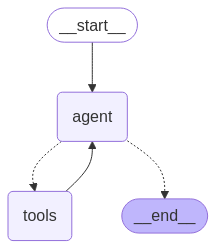

In [116]:
from IPython.display import Image, display

display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [117]:
config = {"configurable": {"thread_id": "abc543"}}

input_message = (
       """
       Use the tools to answer the user's questions.
       Alwasys provide a download link.

       User's question: Please let me know how to set up computer and related things.
       """
)

for event in agent_executor.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
    config=config,
):
    event["messages"][-1].pretty_print()

================================ Human Message =================================


       Use the tools to answer the user's questions. 
       Alwasys provide a download link.

       User's question: Please let me know how to set up computer and related things.
       
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_KGECnPdxq3KRZkB9rj9ODcS1)
 Call ID: call_KGECnPdxq3KRZkB9rj9ODcS1
  Args:
    query: how to set up a computer and related equipment
================================= Tool Message =================================
Name: retrieve

Source: {'producer': 'Microsoft® Word 2013', 'creator': 'Microsoft® Word 2013', 'creationdate': '2018-11-08T10:22:04-06:00', 'author': 'Waggoner, Ashley', 'moddate': '2018-11-08T11:27:10-06:00', 'title': 'Onboarding Toolkit', 'source': '/content/drive/MyDrive/Colab_Notebooks/chatbot_for_onboarding/RAG_data/UH Onboarding Manual.pdf', 'total_pages': 18, 'page': 13, 'page_label': '14'}
Con